# DOE 本番解析用 (base) v6 移動平均・メジアン

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.setting import load_setting
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [4]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## 初期設定

In [5]:
name_doe = "doe-12a"  # 実験計画名（フォルダ名）
path_doe = os.path.join("..", "doe", f"{name_doe}.csv")

name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

df_doe = pd.read_csv(path_doe)
print(df_doe)
factor_doe = list(df_doe.columns)
print(factor_doe)
col_x = factor_doe[0]
col_y = factor_doe[1]

res = AppRes()
dict_setting = load_setting(res, name_code)
df_setting = pd.DataFrame(pd.Series(dict_setting))
df_setting.columns = ["value"]
print("\n設定")
print(df_setting)

x_por = dict_setting[col_x]
y_por = dict_setting[col_y]

# 移動期間
period = 50

     PERIOD_MA_1  PERIOD_MA_2
0             30          300
1             40          300
2             50          300
3             60          300
4             70          300
..           ...          ...
284          150         1100
285          160         1100
286          170         1100
287          180         1100
288          190         1100

[289 rows x 2 columns]
['PERIOD_MA_1', 'PERIOD_MA_2']

設定
                    value
PERIOD_WARMUP      180.00
PERIOD_MA_1        170.00
PERIOD_MA_2        500.00
PERIOD_SLOPE         5.00
THRESHOLD_SLOPE      0.05
PERIOD_RR           30.00
TURBULENCE          35.00
LOSSCUT_1          -25.00
THRESHOLD_PM_MIN    20.00
THRESHOLD_DDR_MIN    0.40


## CSV ファイル一覧の取得

In [6]:
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join(
        "..", "output", name_doe, f"y{m.group(1)}", m.group(2), m.group(3)
    )
    date_str = date_dir
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00", "00")
    date_str = date_dir
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

### 設定情報の保存

In [7]:
# HTML 形式で出力
styled = (
    df_setting.style.format({"value": "{:.3f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_setting.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

## CSV ファイルの読み込み、連結

In [8]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = [col_x, col_y, "trade", "total"]
list_col_new = [col_x, col_y, "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_latest_single.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件 [{name_doe}]")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2
0    ticks_20250819.xlsx  7011    100  2500.0           30          300
1    ticks_20250819.xlsx  7011    100  2700.0           40          300
2    ticks_20250819.xlsx  7011     80 -1900.0           50          300
3    ticks_20250819.xlsx  7011     70 -5000.0           60          300
4    ticks_20250819.xlsx  7011     48  1500.0           70          300
..                   ...   ...    ...     ...          ...          ...
284  ticks_20250819.xlsx  7011      8  2400.0          150         1100
285  ticks_20250819.xlsx  7011      4  -400.0          160         1100
286  ticks_20250819.xlsx  7011      4   900.0          170         1100
287  ticks_20250819.xlsx  7011      4  -500.0          180         1100
288  ticks_20250819.xlsx  7011      2  2500.0          190         1100

[289 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade   total  PERIOD_MA_1  PE

### 本日の条件

## 最終日のデータだけで作成した等高線図

In [9]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

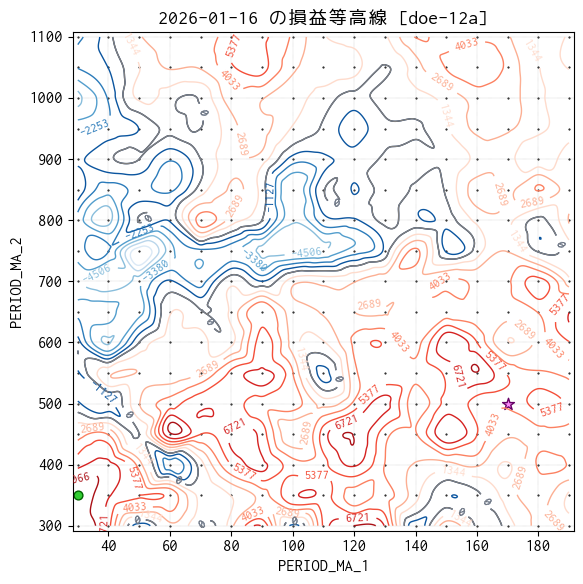

In [10]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

try:
    # z>0 の等高線（暖色）
    levels_pos = np.linspace(0, np.nanmax(Zi), 8)
    cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
    ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

try:
    # z<0 の等高線（寒色）
    levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
    cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
    ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(date_str, f"{name_code}_contour_single.png")

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

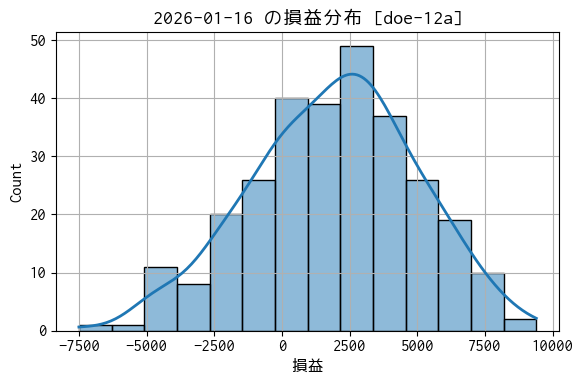

In [11]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [{name_doe}]")

plt.tight_layout()
output = os.path.join(date_str, f"{name_code}_hist_single.png")
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [12]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
15165  ticks_20251105.xlsx  7011     54  31800.0           40          700

最低損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
14495  ticks_20251031.xlsx  7011     64 -24100.0          140          400


## 日付 × 条件 で損益を集計

In [13]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
               0       1       2       3       4       5       6       7    \
2025-08-19  2500.0  2700.0 -1900.0 -5000.0  1500.0  4200.0  2900.0 -3600.0   
2025-08-20  4200.0  2900.0  6600.0  3800.0  5000.0  6600.0  7300.0  6500.0   
2025-08-21  1300.0 -1300.0  2800.0  4900.0  5100.0  4300.0   600.0  1300.0   
2025-08-22 -7300.0 -5000.0 -6000.0 -1700.0 -3700.0 -1500.0  -500.0   500.0   
2025-08-25 -3400.0 -2100.0 -1300.0 -1000.0  -400.0  -200.0  -100.0  -200.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-09 -4300.0 -4700.0 -1600.0 -4700.0 -4100.0 -2800.0 -2200.0 -3000.0   
2026-01-13  2500.0  -300.0  6900.0  4600.0  5200.0  3500.0  5700.0  8400.0   
2026-01-14  6300.0  3200.0  4800.0  1200.0 -5600.0 -2200.0 -1600.0 -2100.0   
2026-01-15  5600.0  9100.0  8800.0  3800.0  9900.0  7800.0  5100.0  2800.0   
2026-01-16  9000.0  5900.0 -2000.0  2200.0     0.0  2200.0  6600.0 -1500.0   

               8       9    ...     279    

## 損益の移動平均のトレンド

In [14]:
# 移動平均
df_ma = df_raw.rolling(window=period, min_periods=1).mean()
print(df_ma)
# データスコープを示す文字列
dt_start = df_ma.index[0]
dt_end = df_ma.index[-1]
title_scope = (
    f"{dict_code[name_code]} ({name_code}) "
    f"from {dt_start.date()} to {dt_end.date()} / "
    f"n={n_day}d / "
    f"rolling={period}d"
)
print("データスコープを示す文字列")
print(title_scope)

                    0            1       2            3            4    \
2025-08-19  2500.000000  2700.000000 -1900.0 -5000.000000  1500.000000   
2025-08-20  3350.000000  2800.000000  2350.0  -600.000000  3250.000000   
2025-08-21  2666.666667  1433.333333  2500.0  1233.333333  3866.666667   
2025-08-22   175.000000  -175.000000   375.0   500.000000  1975.000000   
2025-08-25  -540.000000  -560.000000    40.0   200.000000  1500.000000   
...                 ...          ...     ...          ...          ...   
2026-01-09  -206.000000  -230.000000  -604.0  -496.000000  -730.000000   
2026-01-13  -112.000000  -152.000000  -270.0  -418.000000  -604.000000   
2026-01-14  -196.000000  -350.000000  -490.0  -470.000000  -864.000000   
2026-01-15   -32.000000  -194.000000  -328.0  -380.000000  -618.000000   
2026-01-16   224.000000   -10.000000  -248.0  -164.000000  -470.000000   

                    5       6       7       8            9    ...  \
2025-08-19  4200.000000  2900.0 -3600.0  -

### ランキング（移動平均）

In [15]:
# 最終日の移動平均収益のランキング
ser_ma_ranking = df_ma.iloc[len(df_ma) - 1].sort_values(ascending=False)
n_top = 5

# ベスト条件の抽出
best_ma_conditions = list(ser_ma_ranking.index[:n_top])
df_ma_best = df_latest.iloc[best_ma_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_ma.index[-1]
df_ma_best["損益(MA)"] = (df_ma.loc[dt:][best_ma_conditions].T)[dt]
print("---\n[Best Conditions with latest MA]")
print(df_ma_best)

# HTML 形式で出力
styled = (
    df_ma_best.style.format(
        {"取引回数": "{:.0f}", "損益": "{:.1f}", "損益(MA)": "{:.1f}"}
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_ma_conditions = ser_ma_ranking[ser_ma_ranking < 0].index
if len(negative_ma_conditions) > 0:
    df_ma_negative = df_latest.iloc[negative_ma_conditions].copy()
    df_ma_negative["損益(MA)"] = (df_ma.loc[dt:][negative_ma_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MA]")
    print(df_ma_negative)

---
[Best Conditions with latest MA]
     PERIOD_MA_1  PERIOD_MA_2  取引回数      損益  損益(MA)
123           70          650    56   100.0  1664.0
88            60          550    58  1900.0  1648.0
82           170          500    24  4300.0  1518.0
106           70          600    54  1900.0  1496.0
139           60          700    68 -1000.0  1466.0
---
[Bad Conditions with latest MA]
     PERIOD_MA_1  PERIOD_MA_2  取引回数      損益 備考  損益(MA)
183          160          800    18  1700.0       -2.0
217          160          900    24  1700.0       -6.0
1             40          300   100  5900.0      -10.0
9            120          300    38  8100.0      -10.0
225           70          950    42     0.0      -22.0
199          150          850    24   200.0      -26.0
237          190          950    18   600.0      -44.0
277           80         1100    32  5000.0      -54.0
29           150          350    30 -1000.0      -54.0
197          130          850    24   700.0      -58.0
185       

### 条件毎の損益トレンド（移動平均）のチャート

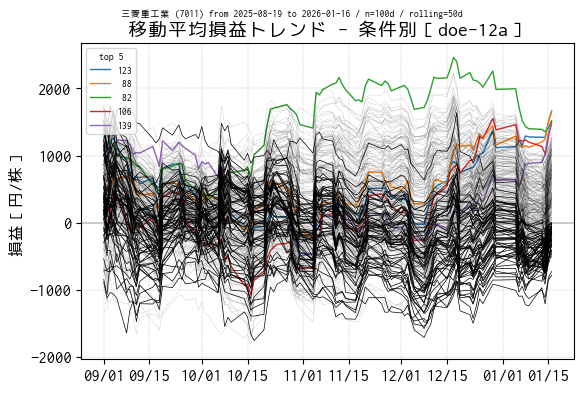

In [16]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_ma[dt_from <= df_ma.index]

for colname in ser_ma_ranking.index:
    if colname in best_ma_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_ma_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動平均損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_ma_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_mean_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 損益の移動メジアンのトレンド

In [17]:
# 移動メジアン
df_mm = df_raw.rolling(window=period, min_periods=1).median()
print(df_mm)

               0       1       2       3       4       5       6       7    \
2025-08-19  2500.0  2700.0 -1900.0 -5000.0  1500.0  4200.0  2900.0 -3600.0   
2025-08-20  3350.0  2800.0  2350.0  -600.0  3250.0  5400.0  5100.0  1450.0   
2025-08-21  2500.0  2700.0  2800.0  3800.0  5000.0  4300.0  2900.0  1300.0   
2025-08-22  1900.0   700.0   450.0  1050.0  3250.0  4250.0  1750.0   900.0   
2025-08-25  1300.0 -1300.0 -1300.0 -1000.0  1500.0  4200.0   600.0   500.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-09  -850.0  -700.0  -400.0 -1300.0 -1200.0  -750.0   -50.0   -50.0   
2026-01-13  -700.0  -600.0  -100.0 -1300.0 -1200.0  -550.0   -50.0   -50.0   
2026-01-14  -700.0  -600.0  -100.0 -1300.0 -1200.0  -750.0  -100.0  -200.0   
2026-01-15  -450.0  -600.0  -100.0 -1300.0 -1200.0  -550.0   -50.0   -50.0   
2026-01-16  -200.0  -450.0  -100.0 -1200.0 -1000.0  -400.0    50.0   -50.0   

               8       9    ...     279     280     281     282

### ランキング（移動メジアン）

In [18]:
# 最終日の移動メジアン収益のランキング
ser_mm_ranking = df_mm.iloc[len(df_mm) - 1].sort_values(ascending=False)
n_top = 10

# ベスト条件の抽出
best_mm_conditions = list(ser_mm_ranking.index[:n_top])
df_mm_best = df_latest.iloc[best_mm_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_mm.index[-1]
df_mm_best["損益(MM)"] = (df_mm.loc[dt:][best_mm_conditions].T)[dt]
print("---\n[Best Conditions with latest MM]")
print(df_mm_best)

# HTML 形式で出力
styled = (
    df_mm_best.style.format(
        {"取引回数": "{:.0f}", "損益": "{:.1f}", "損益(MM)": "{:.1f}"}
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best_median.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_mm_conditions = ser_mm_ranking[ser_mm_ranking < 0].index
if len(negative_mm_conditions) > 0:
    df_mm_negative = df_latest.iloc[negative_mm_conditions].copy()
    df_mm_negative["損益(MM)"] = (df_mm.loc[dt:][negative_mm_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MM]")
    print(df_mm_negative)

---
[Best Conditions with latest MM]
     PERIOD_MA_1  PERIOD_MA_2  取引回数      損益  損益(MM)
54            60          450    70  7800.0  1200.0
43           120          400    40  6900.0  1150.0
139           60          700    68 -1000.0  1000.0
12           150          300    32  3800.0  1000.0
121           50          650    70 -3900.0   950.0
155           50          750    68 -7500.0   850.0
122           60          650    64  1200.0   850.0
222           40          950    72 -2000.0   800.0
143          100          700    40  2100.0   800.0
40            90          400    60  7000.0   800.0
---
[Bad Conditions with latest MM]
     PERIOD_MA_1  PERIOD_MA_2  取引回数      損益 備考  損益(MM)
192           80          850    42  2800.0      -50.0
233          150          950    22  1200.0      -50.0
162          120          750    32 -2900.0      -50.0
158           80          750    48 -2900.0      -50.0
154           40          750    92 -2200.0      -50.0
..           ...         

### 条件毎の損益トレンド（移動メジアン）のチャート

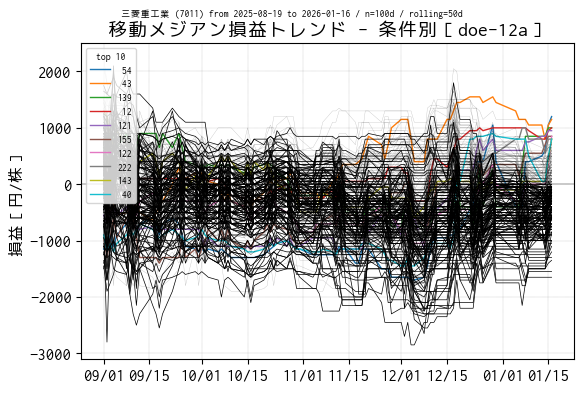

In [19]:
# ---------------------------------------------------------
# 実験条件毎の平均メジアントレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

df_trend = df_mm[dt_from <= df_mm.index]

for colname in ser_mm_ranking.index:
    if colname in best_mm_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_mm_conditions:  # 最新のメジアン収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動メジアン損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_mm_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_median_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

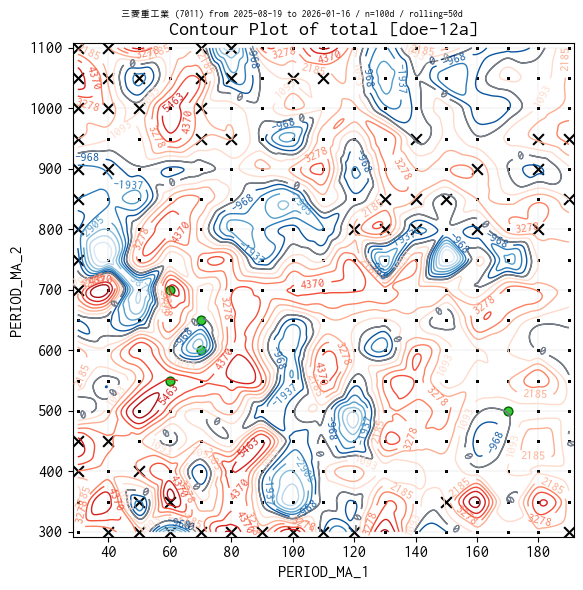

In [20]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"Contour Plot of total [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_ma_best[col_x],
    df_ma_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
if len(negative_ma_conditions) > 0:
    ax.scatter(
        df_ma_negative[col_x],
        df_ma_negative[col_y],
        marker="x",
        color="black",
        s=60,
        zorder=1,
    )

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = os.path.join(date_str, f"{name_code}_raw_contour_{target}.png")
plt.savefig(output)
plt.show()